In [14]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#!{sys.executable} -m pip install bayesian_optimization
from bayes_opt import BayesianOptimization

# SETTINGS
seed = 124
np.random.seed(seed)
np.set_printoptions(precision=14)

test_size = 0.1

In [15]:
def get_data():

    ## train & test paths
    data_dir = "./data/"

    ### csv w/ layout: "y,x1,x2,x3,x4,x5"
    train_features_file = data_dir+"train_features.csv"
    train_labels_file = data_dir+"train_labels.csv"
    test_features_file = data_dir+"test_features.csv"
    
    data_type = np.double # np dtype object for values in X and Y

    train_features = pd.read_csv(train_features_file)
    train_labels = pd.read_csv(train_labels_file)
    test_features = pd.read_csv(test_features_file)

    return train_features, train_labels, test_features

In [16]:
train_features, train_labels, test_features = get_data()

In [17]:
print(train_features.head())
print(train_features.columns)
train_features.info()

   pid  Time   Age  EtCO2  PTT   BUN  Lactate  Temp  Hgb  HCO3  BaseExcess  \
0    1     3  34.0    NaN  NaN  12.0      NaN  36.0  8.7  24.0        -2.0   
1    1     4  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN        -2.0   
2    1     5  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN         0.0   
3    1     6  34.0    NaN  NaN   NaN      NaN  37.0  NaN   NaN         0.0   
4    1     7  34.0    NaN  NaN   NaN      NaN   NaN  NaN   NaN         NaN   

   RRate  Fibrinogen  Phosphate  WBC  Creatinine  PaCO2  AST  FiO2  Platelets  \
0   16.0         NaN        NaN  6.3         NaN   45.0  NaN   NaN        NaN   
1   16.0         NaN        NaN  NaN         NaN    NaN  NaN   0.5        NaN   
2   18.0         NaN        NaN  NaN         NaN   43.0  NaN   0.4        NaN   
3   18.0         NaN        NaN  NaN         NaN    NaN  NaN   NaN        NaN   
4   18.0         NaN        NaN  NaN         NaN    NaN  NaN   NaN        NaN   

   SaO2  Glucose  ABPm  Magnesium  Potassium

In [18]:
# means = train_features.mean()
# # train_features.fillna(0, inplace=True)
# train_features.fillna(means, inplace=True)
# train_features.head()

# train_feature_labels = train_features.columns

# column_names = [f"{label}_{i}" for i in range(12) for label in train_feature_labels]


In [19]:
from tqdm import tqdm
def reshape(train_features):
    preprocessed_train_features_arr = []
    grouped_pid = train_features.groupby("pid")
    for pid, group in tqdm(grouped_pid):
        # print(group)

        row_arr = []
        min_time = group['Time'].min()
        means = group.mean()
        # print("pre", group)
        group.fillna(means, inplace=True)
        group.fillna(0.0, inplace=True)
        group.astype(float)
        # print(group)
        for i, row in group.iterrows():
            # row = row.to_frame()
            age = row["Age"]
            time = int(row["Time"] - min_time)
            row = row.drop(["pid", "Age", "Time"])
            row = row.add_suffix(f"_{str(time)}")
            row_arr.append(row)
        # print(df)

        pid_age_df = pd.DataFrame({"pid": pid, "Age": float(age)}, index=[0]).T
        
        # column_names = [f"{label}_{i}" for i in range(12) for label in pid_age_df.columns ].append("pid", "Age")
        row_arr.append(pid_age_df)
        final_row = pd.concat(row_arr)
        # print("row_arr", final_row, "end_row_arr", len(row_arr))

        preprocessed_train_features_arr.append(final_row.T)
        


    preprocessed_train_features = pd.concat(preprocessed_train_features_arr, axis=0, ignore_index=True)

    return preprocessed_train_features

# preprocessed_train_features = reshape(train_features)
# preprocessed_train_features.to_csv("./data/preprocessed_train_features.csv")
pd.set_option('display.max_columns', None)
# preprocessed_train_features.head()

In [20]:
preprocessed_train_features = pd.read_csv("./data/preprocessed_train_features.csv")

In [21]:
# 1. Subtask
labels_to_predict = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2"]
y1 = train_labels[labels_to_predict]
print(y1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18995 entries, 0 to 18994
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LABEL_BaseExcess        18995 non-null  float64
 1   LABEL_Fibrinogen        18995 non-null  float64
 2   LABEL_AST               18995 non-null  float64
 3   LABEL_Alkalinephos      18995 non-null  float64
 4   LABEL_Bilirubin_total   18995 non-null  float64
 5   LABEL_Lactate           18995 non-null  float64
 6   LABEL_TroponinI         18995 non-null  float64
 7   LABEL_SaO2              18995 non-null  float64
 8   LABEL_Bilirubin_direct  18995 non-null  float64
 9   LABEL_EtCO2             18995 non-null  float64
dtypes: float64(10)
memory usage: 1.4 MB
None


In [22]:
for label in labels_to_predict:
    print(label)
    wanted_features = [l for l in preprocessed_train_features.columns if "_".join(label.split("_")[1:]) in l]
    wanted_features.append("Age")
    # print(wanted_features)
    X_train_filtered = preprocessed_train_features[wanted_features]
    X_test_filtered = preprocessed_train_features[wanted_features]
    print(X_train_filtered)

LABEL_BaseExcess
       BaseExcess_0  BaseExcess_1  BaseExcess_2  BaseExcess_3  BaseExcess_4  \
0         -2.000000          -2.0      0.000000           0.0     -0.666667   
1          0.000000           0.0      0.000000           0.0      0.000000   
2          0.000000           0.0      0.000000           0.0      0.000000   
3         -2.857143          -2.0     -2.857143          -4.0     -2.000000   
4          0.000000           0.0      0.000000           0.0      0.000000   
...             ...           ...           ...           ...           ...   
18990      0.000000           0.0      0.000000           0.0      0.000000   
18991      0.000000           0.0      0.000000           0.0      0.000000   
18992     -3.500000          -5.0     -3.500000          -5.0     -3.500000   
18993      0.000000           0.0      0.000000           0.0      0.000000   
18994      0.000000           0.0      0.000000           0.0      0.000000   

       BaseExcess_5  BaseExcess_6 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_features, y1, test_size=test_size, random_state=seed)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [24]:
X_train, y_train

(       Unnamed: 0  EtCO2_0  PTT_0  BUN_0  Lactate_0     Temp_0  Hgb_0  HCO3_0  \
 1055         1055      0.0   0.00   19.0   1.500000  36.500000   8.75     0.0   
 7611         7611      0.0   0.00   16.0   0.000000  36.666667  11.30    26.0   
 10976       10976      0.0  27.75   50.5   2.500000  36.666667   9.80    20.5   
 10171       10171      0.0   0.00    0.0   0.000000  36.666667   0.00     0.0   
 94             94      0.0  29.90   62.0   0.000000  36.500000  13.15    30.0   
 ...           ...      ...    ...    ...        ...        ...    ...     ...   
 681           681      0.0   0.00    9.0   0.000000  36.333333  10.90     0.0   
 9154         9154      0.0   0.00   34.0   2.923333  36.909091  10.00     0.0   
 14353       14353      0.0   0.00   24.0   2.850000  38.000000  13.20    26.0   
 4764         4764      0.0  34.00    0.0   0.000000  37.000000   0.00     0.0   
 4558         4558      0.0   0.00   18.0   0.000000  37.000000  13.70    23.0   
 
        BaseEx

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17095 entries, 1055 to 4558
Columns: 411 entries, Unnamed: 0 to Age
dtypes: float64(410), int64(1)
memory usage: 53.7 MB


       Unnamed: 0  EtCO2_0  PTT_0  BUN_0  Lactate_0     Temp_0  Hgb_0  HCO3_0  \
0               0      0.0    0.0   12.0        0.0  36.000000   8.70    24.0   
2               2      0.0   34.6    8.0        0.0  36.666667  10.55     0.0   
3               3      0.0   53.8   32.0        1.8  35.000000  10.60    20.0   
4               4      0.0    0.0   18.0        0.0  36.000000   0.00     0.0   
5               5      0.0   27.8   12.0        0.0  36.000000  14.60     0.0   
...           ...      ...    ...    ...        ...        ...    ...     ...   
18989       18989      0.0   25.2   17.0        1.6  36.666667   9.80    25.0   
18991       18991      0.0    0.0   33.0        0.0  37.500000  11.20     0.0   
18992       18992      0.0    0.0   15.0        0.0  38.000000  12.40    24.0   
18993       18993      0.0    0.0    0.0        0.0  36.500000   0.00     0.0   
18994       18994      0.0    0.0   13.0        0.0  36.500000  14.40     0.0   

       BaseExcess_0    RRat

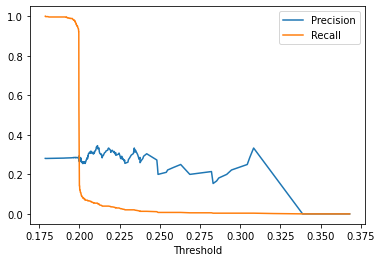

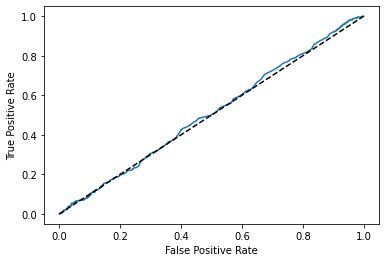

LABEL_Fibrinogen
[0.19999372700705 0.20008168749092 0.20004609437985 ... 0.20016613972336
 0.20022232709002 0.20003331915946]
roc auc score: 0.4999958316659998


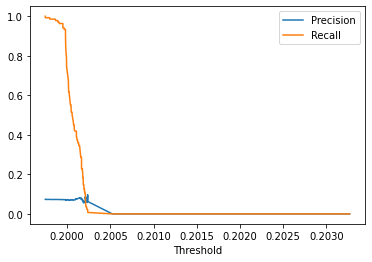

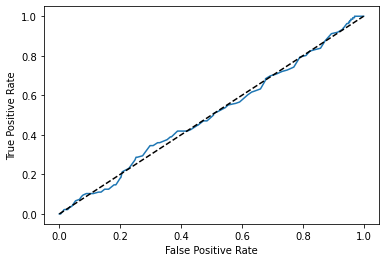

LABEL_AST
[0.20004643646594 0.20018543840528 0.20013604448984 ... 0.20026453471882
 0.2001025691185  0.20005334402262]
roc auc score: 0.48169384057971015


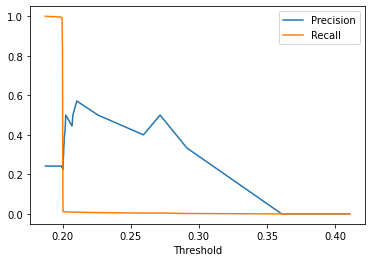

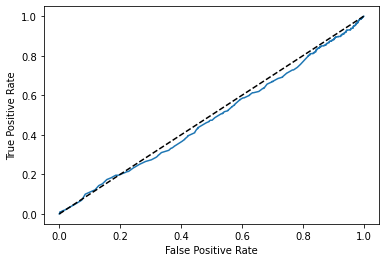

LABEL_Alkalinephos
[0.20046291097379 0.20040748906652 0.20043310118412 ... 0.20032094202
 0.20024253286812 0.20043353727444]
roc auc score: 0.5066471959250953


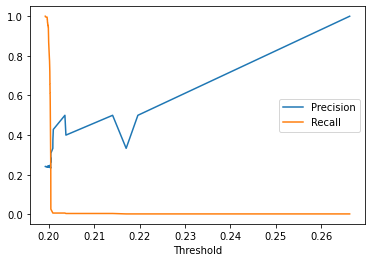

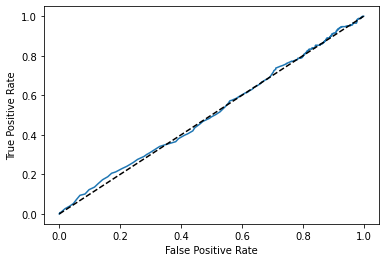

LABEL_Bilirubin_total
[0.20037443422233 0.20038471650064 0.20038272884804 ... 0.20037449944932
 0.20026750985897 0.20036370157108]
roc auc score: 0.49167968586324756


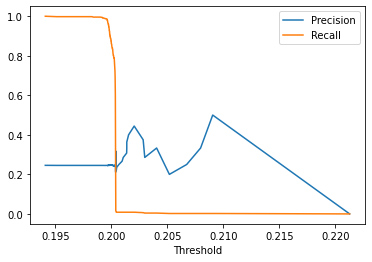

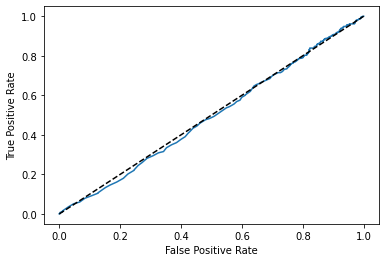

LABEL_Lactate
[0.19969844086308 0.20000105605704 0.2000300438762  ... 0.19990793754834
 0.19984565669085 0.20003880333627]
roc auc score: 0.530156480588035


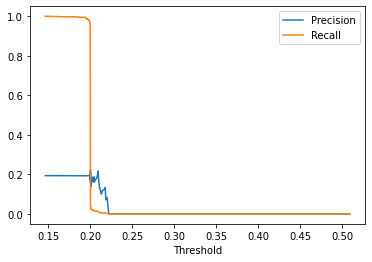

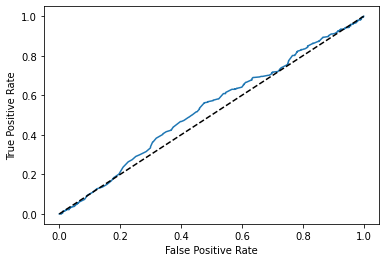

LABEL_TroponinI
[0.19993698380282 0.20009680778015 0.20008686124044 ... 0.20011626474149
 0.19971095251637 0.19995185948581]
roc auc score: 0.5088495871419918


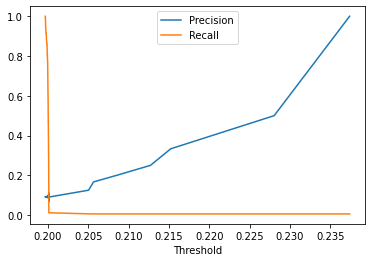

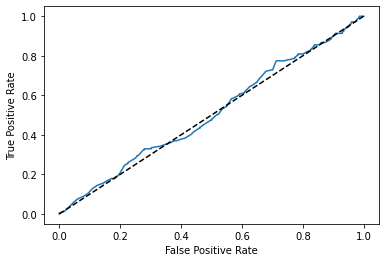

LABEL_SaO2
[0.200262786333   0.20027550587939 0.20002751624123 ... 0.20026786399358
 0.20007393594703 0.20021812363273]
roc auc score: 0.498076706848699


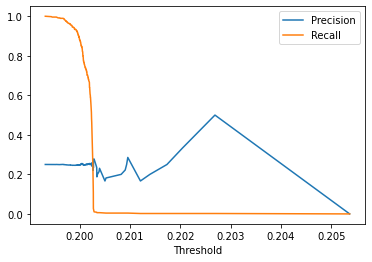

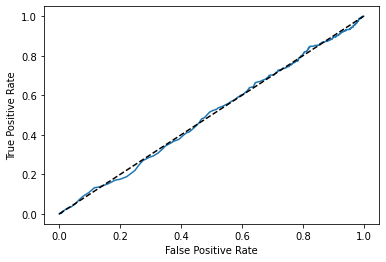

LABEL_Bilirubin_direct
[0.20031533549502 0.200159516613   0.20022039926238 ... 0.20000965037392
 0.20004551610205 0.20033692117285]
roc auc score: 0.5006553338260655


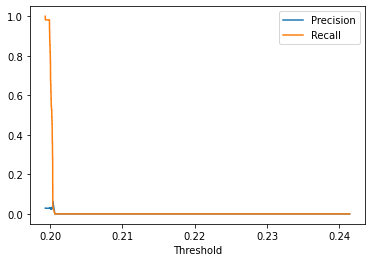

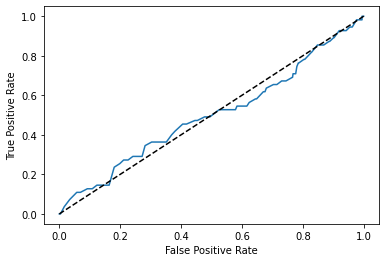

LABEL_EtCO2
[0.20032535529936 0.20025987775699 0.20029633118779 ... 0.20013984860931
 0.19979687954671 0.20014547159118]
roc auc score: 0.5155256475368207


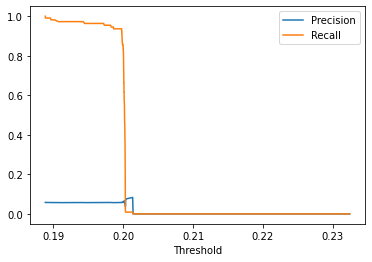

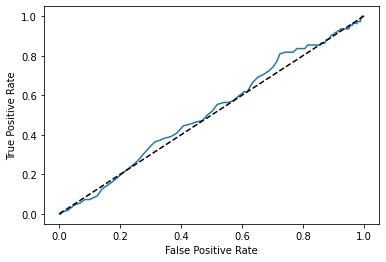

In [45]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

X_train.sort_values('pid', inplace=True)
y_train.sort_index(inplace=True)

print(X_train, y_train)
for label in labels_to_predict:
    print(label)
    # clf = LogisticRegressionCV(class_weight='balanced', n_jobs=6, cv=10, max_iter=200, scoring="roc_auc", random_state=seed)
    # clf = LinearSVC(probability=True, class_weight='balanced', kernel='linear')
    regr = make_pipeline(StandardScaler(), SVR(C=0.5, epsilon=0.2))
    
    
    # cv = RandomizedSearchCV(logistic, distributions, random_state=0)
    # search = RandomCV(pipe, param_grid, n_jobs=2)
    # search.fit(X_digits, y_digits)
    # print("Best parameter (CV score=%0.3f):" % search.best_score_)
    # print(search.best_params_)

    wanted_features = [l for l in X_train.columns if "_".join(label.split("_")[1:]) in l]
    wanted_features.append("Age")
    # print(wanted_features)
    X_train_filtered = X_train[wanted_features]
    X_test_filtered = X_test[wanted_features]
    # print(X_train_filtered)
    
    # scaler = preprocessing.StandardScaler().fit(X_train_filtered)    
    # X_train_scaled = scaler.transform(X_train_filtered)
    # X_test_scaled = scaler.transform(X_test_filtered)
    # clf.fit(X_train_scaled, y_train[label])

    regr.fit(X_train_filtered, y_train[label])

    # model = Sequential() # create a sequential model
    # model.add(Dense(1000, # output neurons in layer       
    #         input_dim=X_train.shape[1], # number of inputs
    #         activation='relu')) # activation function
    # model.add(Dense(1000, activation='relu')) # hidden layer
    # model.add(Dense(1000, activation='relu')) # hidden layer
    # model.add(Dense(1000, activation='relu')) # hidden layer
    # # model.add(Dense(800, activation='relu')) # hidden layer
    # model.add(Dense(1, activation='sigmoid')) # output layer
    # model.summary()

    # fit the model
    # callback = EarlyStopping(monitor='loss', patience=2)
    # model.compile(loss='binary_crossentropy', # cost function
    #           optimizer='adam', # use adam as the optimizer
    #           metrics=['accuracy', keras.metrics.AUC()]) # compute accuracy, for scoring
    # model_info = model.fit(X_train, y_train[label], 
    #     epochs=18,
    #     validation_split=.15,
    #     callbacks=[callback])
    # pred = model.predict(X_test).squeeze()
    pred = regr.predict(X_test_filtered)
    # pred = clf.predict_proba(X_test_scaled)

    print(pred)
    # score = roc_auc_score(y_test[label], pred[:, 1])
    score = roc_auc_score(y_test[label], pred)
    print(f"roc auc score: {score}")


    # precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred[:, 1])
    precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred)

    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    # mean_squared_error(y_test["LABEL_BaseExcess"], pred[:, 1])
    # fpr, tpr, thresholds = roc_curve(y_test[label], pred[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test[label], pred)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [ ]:
def save_submission(submission):

    ## prediction submission paths
    sub_dir = "./submission/"
    sub_file = "submission.csv"
    sub_path = sub_dir + sub_file


    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)


    ## submission csv header
    sub_header = ""
    sub_format = "%.13f"
    np.savetxt(sub_path,
               submission,
               fmt = sub_format,
               delimiter = ',',
               header = sub_header,
               comments = '')